<h1 align="right" style="color:Black"> Выявление профилей потребления Интернет-магазина товаров для дома и быта «Пока все ещё тут»</h1>

# Материалы
* [Презенация] (https://drive.google.com/file/d/1cR7-hxKuoBpCVJyGATsA8ErOtCFvyPIM/view?usp=sharing)
* [Дашборд] (https://public.tableau.com/shared/DCBYKBQCM?:display_count=n&:origin=viz_share_link)

# Задача

Сегментировать покупателей по профилю потребления

1) Провести исследовательский анализ данных;

2) Сегментировать покупателей на основе истории их покупок:

- Выдвинуть собственные варианты сегментации покупателей. Как сегментация может помочь в разработке более персонализированных предложений для покупателей?

- Сформировать сегменты на основе того, что покупают пользователи. Для этого нужно проанализировать их покупки и сегментировать товары на основе принадлежности к той или иной товарной категории.

3) Сформулировать и проверить статистические гипотезы

## Подключение библиотек

In [1]:
import pandas as pd
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

pd.options.mode.chained_assignment = None  # default='warn'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) #делаем блокнот широкоформатным

## Предобработка данных

Загрузим файл с данными и выведем общую информацию на экран

In [2]:
ecommerce = pd.read_csv('/datasets/ecommerce_dataset.csv')
display(ecommerce.head())
display(ecommerce.info())

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

Таблица выводится без видимых замечаний; пропуски отсутствуют, название столбцов в порядке, как и типы данных в столбцах.

Проверим данные на дубликаты

In [3]:
ecommerce.duplicated().sum()

0

Дубликаты не найдены

**Вывод:** данные готовы к дальнейшей работе с ними

## Исследовательский анализ данных

### Выделение категорий товаров

Для начала найдем число уникальных продуктов

In [4]:
ecommerce['product'].nunique()

2343

А теперь - самые покупаемые

In [5]:
ecommerce['product'].value_counts().head(20)

Рассада Кабачка сорт Зебра кассета 6 шт E6                              79
Рассада Кабачка сорт Золотинка кассета 6 шт E6                          78
Рассада Кабачка сорт Белогор кассета 6 шт E6                            77
Рассада Огурец Фараон ячейки по 6 шт Е6                                 76
Рассада Огурца сорт Каролина кассета 6 шт E6                            76
Пеларгония розебудная Red Pandora укорененный черенок                   76
Тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт    76
Рассада Кабачка сорт Горный, кассета по 6шт                             76
Рассада Кабачка сорт Аэронавт, кассета по 6шт                           76
Рассада Кабачка сорт Сосновский, кассета по 6шт                         75
Рассада Патиссона сорт НЛО Белый, кассета по 6шт                        75
Рассада Патиссона сорт Диск, кассета по 6шт                             74
Рассада Огурец Кристина ячейки по 6 шт Е6                               74
Сумка-тележка 2-х колесна

Как мы видим, в топе, в основном, рассада различных растений. Также отметим, что названия товаров могут быть весьма разнообразными и чёткой структуры в них не замечено, поэтому разобьем каждое название на леммы (отдельные слова в начальной форме) и найдем количество упоминаний

In [6]:
products = ecommerce['product'].unique()
lemmas = []
for str in products: 
    lemmas += [x for x in m.lemmatize(str) if x != '\n' and x != ' ' and x != ', ' and x != ',' and x != '-']
    
print(Counter(lemmas))

Counter({'см': 1063, 'для': 547, 'в': 274, 'с': 254, 'л': 253, 'd': 252, 'рассада': 221, '5': 190, 'белый': 173, ' (': 172, 'сорт': 171, 'кассета': 170, 'шт': 169, '0': 164, '12': 148, 'белье': 144, 'красный': 144, ') ': 140, '/': 133, 'доска': 132, 'горшок': 130, '9': 123, 'сушилка': 120, 'цветок': 118, 'объем': 114, 'гладильный': 113, '2': 113, '6': 110, 'тележка': 108, '1': 108, '. ': 106, 'по': 101, '4': 101, '10': 100, 'томат': 100, 'сумка': 98, 'диам': 95, 'помидор': 93, '*': 90, '№': 88, 'пеларгония': 86, 'розовый': 84, 'из': 82, '3': 82, 'и': 81, 'Luminarc': 79, 'хозяйственный': 77, '7': 75, 'ника': 75, '20': 73, 'среднеспелый': 73, 'коврик': 72, 'ванный': 72, 'кухня': 71, 'роза': 70, 'зелень': 68, 'муляж': 68, 'черный': 67, 'мл': 67, 'синий': 63, 'махровый': 62, 'h': 61, 'Gimi': 61, 'м': 61, 'г': 61, 'зональный': 61, 'искусственный': 61, 'чехол': 60, 'Attribute': 60, 'пластмассовый': 59, '100': 58, 'однолетний': 57, 'пластиковый': 54, 'штора': 54, 'штука': 54, 'ручка': 53, '30

Самые упоминаемые слова: "см", "для", "в", "с"... Но по данным словам мы не можем однозначно отнести товар к какой-либо категории. Первое слово, которое нам интересно - "рассада" - по нему сразу можно сказать, что это рассада, или отнести товар к категории "Сад", например.

На основании числа упоминаний выделим категории и подберем такие списки слов для каждой, чтобы покрыть ими все товары

In [7]:
plants = [
    'рассада', 'сорт', 'кассета', 'горшок', 'томат', 'помидор', 'пеларгония', 'среднеспелый', 'роза', 'зелень', 'однолетний',\
    'индетерминантный', 'петуния', 'раннеспелый', 'капуста', 'садовый', 'детерминантный', 'герань', 'огурец', 'цвести', 'кашпо',\
    'укоренять', 'мята', 'чайногибридный', 'фуксия', 'примула', 'калибрахоа', 'тимьян', 'цикламен', 'растение', 'цветок', 'адиантум',\
    'азалий', 'аквилегия', 'алиссум', 'алоэ', 'альбук', 'анемон', 'антуриум', 'аптений', 'арбуз', 'артемизия', 'аспарагус', 'астра',\
    'афеляндр', 'бадан', 'базилик', 'бакоп', 'баклажан', 'бальзамин', 'барвинок', 'бархатцы', 'бегония', 'бузульник', 'вербейник',\
    'вербена', 'вероника', 'виола', 'гайлардий', 'гардения', 'гвоздик', 'георгин', 'гербер', 'гимнокалициум', 'гипсофил', 'глоксиния',\
    'годеция', 'горох', 'гортензия', 'виноград', 'дендробиум', 'джункус', 'диффенбахий', 'драцена', 'душица', 'дыня', 'замиокулькас',\
    'зверобой', 'земляника', 'импатиенс', 'плющ', 'клен', 'иссоп', 'каланхое', 'калатея', 'календула', 'калла', 'каллун', 'калоцефалус',\
    'камнеломка', 'кампануть', 'капсикум', 'клубника', 'колокольчик', 'кореопсис', 'косметь', 'котовник', 'крассула', 'кофе', 'лаванда',\
    'лаватер', 'лавр', 'лантан', 'лапчатка', 'лен', 'лилейник', 'литопс', 'лобелия', 'маттиола', 'мединилла', 'мелисса', 'мимоза', 'мирт',\
    'молодило', 'монарда', 'морковь', 'муррайя', 'настурция', 'незабудка', 'нефролепис', 'ромашка', 'ель', 'нолина', 'осина',\
    'папоротник', 'пахира', 'пеперомия', 'петрушка', 'пиретрум', 'платикодон', 'гиацинт', 'тюльпан', 'подсолнечник', 'микс', 'пуансетия',\
    'пуансеттия', 'радермахер', 'ранункулус', 'розмарин', 'рудбекия', 'салат', 'сантолина', 'седум', 'скиммий', 'смолевка', 'соланум',\
    'солидаго', 'спатифиллум', 'укроп', 'фаленопсис', 'фатсия', 'фиалка', 'физостегия', 'фикус', 'фиттоний', 'флокс', 'хамедорей',\
    'хлорофитум', 'хризантема', 'хризолидокарпус', 'цинерария', 'цинния', 'циперус', 'цитрофортунелла', 'чабер', 'шеффлер',\
    'эвкалипт', 'энотера', 'эпипремнум', 'эхеверие', 'эхинокактус', 'эшшольций', 'юкка', 'ясколка'
]
dacha = ['корыто', 'котел', 'урна', 'почтовый']
home = [
    'белье', 'доска', 'сушилка', 'гладильный', 'коврик', 'штора', 'комната', 'вешалка', 'придверный', 'напольный',\
    'потолочный', 'корзина', 'швабра', 'утюг', 'антинакипин', 'окно', 'бельевой',\
    'ваза', 'веник', 'коробка', 'комод', 'корзинка', 'короб', 'кофр', 'обувной', 'халат', 'прищепок', 'наволочка',\
    'наматрасник', 'наматрацник', 'наматрицник', 'моп', 'обувница', 'одеяло', 'окномойка', 'картина', 'вещь', 'перчатка',\
    'плед', 'плечики', 'подголовник', 'подкладка', 'пододеяльник', 'подрукавник', 'подушка', 'покрывало', 'обувь', 'полка',\
    'простыня', 'пылесос', 'пуф', 'глажение', 'светильник', 'сметка', 'совок', 'одежда', 'ролик', 'пол', 'термометр', 'тряпка',\
    'чехол', 'щетка', 'микрофибры', 'хранение', 'фоторамка', 'тряпкодержатель'
]
bathroom = [
    'ванна', 'ванная', 'ванный', 'вантуз', 'известковый', 'стирка', 'стиральный', 'туалет', 'туалетный', 'мыло', 'зубной', 'полотенце',\
    'отбеливатель', 'унитаз', 'унитазный' 'засор', 'увлажнять', 'чистить', 'фен', 'гигиенический', 'сантехника', 'труднодоступный', 'ерш',\
    'засор'
]
repair = [
    'стремянка', 'строительный', 'завертка', 'угольник', 'крепеж', 'крючок', 'линейка', 'инструмент', 'напильник',\
    'сверло', 'свереть', 'валик', 'веревка', 'основание', 'полировка', 'петля', 'бензин', 'пружина', 'пьезозажигалка',\
    'рассекатель', 'вентиляционный', 'мебельный', 'скоба', 'фал', 'сварка', 'фиксатор', 'шнур', 'шпагат', 'штангенциркуль',\
    'стяжка', 'уголок'
]
kitchen = [
    'кухня', 'муляж', 'тарелка', 'скатерть', 'пищевой', 'банка', 'нож', 'салатник', 'чайник', 'кружка',\
    'термокружок', 'бутылка', 'бутылочный', 'таз', 'разделочный', 'антижир', 'бидон', 'посуда', 'бидон', 'блюдо', 'блюдце',\
    'бульонница', 'ведро', 'венчик', 'весы', 'вилка', 'свч', 'посудомоечный', 'дуршлаг', 'губка', 'столовая', 'столовый',\
    'чайный', 'чайная', 'соус', 'картофелемялка', 'кастрюля', 'кипятильник', 'выпечка', 'запекание', 'ковш', 'контейнер',\
    'салфетка', 'кувшин', 'холодец', 'лопатка', 'лоток', 'мантоварка', 'масленка', 'стакан', 'миксер', 'сковорода', 'миска',\
    'бокал', 'фужер', 'кекс', 'ножеточка', 'овощ', 'овощеварка', 'овощечистка', 'овсянница', 'орехоколка', 'отделитель', 'половник',\
    'пресс', 'просеиватель', 'противень', 'яйцо', 'жестяной', 'рыбочистка', 'салфетница', 'сахарница', 'сито', 'скалка',\
    'соковарка', 'соковыжималка', 'сотейник', 'кондитерский', 'терка', 'термос', 'толкушка', 'тортница', 'хлебница',\
    'электроштопор', 'бутылочный', 'бутылка'
]
bags = ['тележка', 'сумка']

Напишем функцию по распределению товаров по категориям и применим ее к нашему набору данных

In [8]:
def categorize(name): #функция для распределения товаров по ключевым словам
    lemm = m.lemmatize(name)
    if 'разделочный' in lemm:
        return 'для кухни'
    if 'термостакан' in lemm:
        return 'для кухни'
    if 'рассада' in lemm:
        return 'растения'
    if 'кухонный' in lemm:
        return 'для кухни'
    if 'Львиный зев' in name:
        return 'растения'
    if 'Снежные одежды' in name:
        return 'растения'
    if 'Коврик противоскользящий' in name:
        return 'для ванной'
    if 'для посуды' in name:
        return 'для кухни'
    if 'ель' in lemm:
        return 'растения'
    if 'бутылочный' in lemm or 'бутылка' in lemm:
        return 'для кухни'
    if 'подарочный' in lemm:
        return 'растения'
    
    for word in dacha:
        if word in lemm: 
            return 'для дачи'
    for word in bathroom:
        if word in lemm: 
            return 'для ванной'
    for word in home:
        if word in lemm: 
            return 'для дома'
    for word in repair:
        if word in lemm: 
            return 'для ремонта'
    for word in bags:
        if word in lemm: 
            return 'сумки, тележки'
    for word in kitchen:
        if word in lemm: 
            return 'для кухни'
    for word in plants:
        if word in lemm: 
            return 'растения'
    return 'другое'
        
ecommerce['category'] = ecommerce['product'].apply(categorize)

Проверим, не осталось ли товаров без категории

In [9]:
print('Количество наименований товаров, оставшихся без категории: ',ecommerce[ecommerce['category'].isna()]['product'].nunique())

Количество наименований товаров, оставшихся без категории:  0


Посмотрим на распределение товаров по категориям

In [10]:
display(ecommerce['category'].value_counts())

растения          4045
для дома          1052
для кухни          764
сумки, тележки     455
для ванной         252
для ремонта        148
для дачи            21
Name: category, dtype: int64

...и на сами списки товаров

In [11]:
print('Растения:\n',ecommerce[ecommerce['category'] == 'растения']['product'].sort_values().unique())

Растения:
 ['Агератум рассада однолетних цветов в кассете по 10 шт'
 'Адиантум Лиза d-12 см' 'Азалия Индика Биколор d-12 см h-20'
 'Азалия Индика розовая d-12 см h-20'
 'Азалия Индика фиолетовая d-10 см h-20' 'Азалия индика Биколор d-12 см'
 'Аквилегия махровая Тауэр смесь окрасок объем 1 л'
 'Аквилегия обыкновенная Барлоу микс объем 1 л'
 'Алиссум (лобулярия) Снежные одежды 0,2 г 4650091480302'
 'Алиссум Скальный желтый объем 1 л'
 'Алиссум рассада однолетних цветов в кассете по 10 шт'
 'Алиссум рассада однолетних цветов в кассете по 6 шт'
 'Алоэ Вера d-12 см h-25 см' 'Альбука Спиралис Фризл-Сизл d-12 см'
 'Амариллис Red Lion темно-красный в горшке d-12 см 1 луковица'
 'Анемона белый объем 0,5 л' 'Антуриум Андрианум розовый d-12 см'
 'Антуриум Тропик Найт НИДЕРЛАНДЫ 1 штука в упаковке'
 'Антуриум андрианум Блэк d-12 см' 'Антуриум андрианум Ванилла d-12 см'
 'Антуриум андрианум Многоцветковый Красный d-12 см'
 'Антуриум андрианум Пикассо голубой d-15 см'
 'Антуриум андрианум Фиорино d-

In [12]:
ecommerce[ecommerce['category'].isna()]['product'].sort_values().reset_index(drop=True).head(50)

Series([], Name: product, dtype: object)

In [13]:
print('Для дома:\n',ecommerce[ecommerce['category'] == 'для дома']['product'].sort_values().unique())

Для дома:
 ['Автоматическая щетка Leifheit для мытья окон с ручкой 43 см. 51114'
 'Антинакипин для утюгов Ампулы 10 мл по 5 шт UN MOMENTO Россия 4627096350107'
 'Бак для белья Hailo 0744-221, 44 л, стальной'
 'Бельевые прищепки YORK АЗУР эко деревянные 20 шт z029 G1529'
 'Бельевые прищепки YORK Классик 20 шт G96010'
 'Ваза МАСКАРАД 24 см G5541 Luminarc Франция'
 'Вакуумный пакет EVA для хранения вещей 50х85 см EVEC0085'
 'Ведро овальное с отжимом и шваброй моп с черенком Centi, 8 л, высота 22 см, York/7218'
 'Веник для подметания из сорго 225 г 2 шва'
 'Веник для подметания из сорго LUX 400-450 г 3 шва 5 колец'
 'Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204'
 'Весы напольные Edition Feet механические'
 'Весы напольные механические Дельта D-2017 130 кг, 1205224'
 'Весы напольные электронные Soehnle Pino White, 63747'
 'Вешалка - слуга Малая ЗМИ белое серебро ВНП 141 б'
 'Вешалка Valiant для брюк и юбок металлическая 30*10.5 см 121B11'
 'Вешалка НИКА Комфорт 6 напольна

In [14]:
print('Для кухни:\n',ecommerce[ecommerce['category'] == 'для кухни']['product'].sort_values().unique())

Для кухни:
 ['Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759'
 'Tepмокружка AVEX Freeflow 700 мл сталь AVEX0776'
 'Tepмокружка AVEX Recharge 500 мл голубой AVEX0681'
 'Ёрш бутылочный с металлической ручкой малый Y64 1807002'
 'Ёрш для бутылки из натурального волокна и металла 23 см кремовый, Burstenmann, 0473/0003'
 'Антижир POSH ONE MAGNUM 828 мл Россия 4580390-927058'
 'Бальзам для мытья посуды Mama Ultimate EcoSoda 1000 мл Россия 044684'
 'Банка РОНДО ВАЛЕНСИЯ 1л, G8494, Luminarc, Китай'
 'Банка РОНДО ЭЛИЗ 1л, G8487, Luminarc, Китай'
 'Банка из стекла для сыпучих продуктов круглой с пластмассовой крышкой и цветной вкладкой 1,0л 10МР-0001'
 'Банка с крышкой Attribute 500 мл и бугельным замком JAR500'
 'Банка с крышкой Attribute 760 мл и бугельным замком JAR760'
 'Банка с металлической крышкой, COLOR SERIES, круглая, 11*11*12 см, 960 мл VALIANT, JK-D960'
 'Банка с металлической крышкой, COLOR SERIES, круглая, 11*11*17 см, 1350 мл VALIANT, JK-C1350'
 'Банка со стеклянной крышкой, CO

In [15]:
print('Сумки, тележки:\n',ecommerce[ecommerce['category'] == 'сумки, тележки']['product'].sort_values().unique())

Сумки, тележки:
 ['Сумка для тележки большая комбинированная 45*30*25, 1209021'
 'Сумка для тележки малая комбинированная, 1209024'
 'Сумка хозяйственная на колесах, 1209020'
 'Сумка-тележка 2-х колесная Gimi Argo красная'
 'Сумка-тележка 2-х колесная Gimi Argo синяя'
 'Сумка-тележка 2-х колесная Gimi Argo фиолетовая'
 'Сумка-тележка 2-х колесная Gimi Argo фуксия'
 'Сумка-тележка 2-х колесная Gimi Argo черная'
 'Сумка-тележка 2-х колесная Gimi Family синяя'
 'Сумка-тележка 2-х колесная Gimi Galaxy голубая'
 'Сумка-тележка 2-х колесная Gimi Galaxy красная'
 'Сумка-тележка 2-х колесная Gimi Galaxy черная'
 'Сумка-тележка 2-х колесная Gimi Ideal синяя'
 'Сумка-тележка 2-х колесная складная Gimi Flexi зеленая'
 'Сумка-тележка 2-х колесная складная Gimi Flexi серая'
 'Сумка-тележка 3-х колесная Gimi Tris Floral синяя'
 'Сумка-тележка 3-х колесная Gimi Tris красная'
 'Сумка-тележка 3-х колесная Gimi Tris черная' 'Сумка-тележка Brava Plus'
 'Сумка-тележка DELTA ТБР-20 синий грузоподъемность 2

In [16]:
print('Для ванной:\n',ecommerce[ecommerce['category'] == 'для ванной']['product'].sort_values().unique())

Для ванной:
 ['Ёрш радиаторный без ручки 1807007'
 'Ёрш унитазный пластмассовый, Ваир 1712002'
 'Ёрш унитазный с деревянной ручкой , Ваир 1712012'
 'Ёрш унитазный с подставкой WC "Люкс", Мультипласт, 1712007'
 'Ёрш унитазный с подставкой WC "Стандарт", Мультипласт 1712010'
 'Ароматизированное средство дудаления известкового налета и ржавчины DECS WC Гель Лимон 750 мл Россия 4660015923235'
 'Ванна 70 л оцинкованная г.Магнитогорск, 1301016'
 'Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000'
 'Вантуз черный с длинной ручкой (D-110 мм, L-380 мм), 1206007'
 'Вантуз черный с пластиковой ручкой малый Д-100 (МАГ), 1206002'
 'Гипоаллергенный концентрированный гель для стирки белья VPK для деликатных тканей 2,5 л Корея 8809473130144'
 'Держатель для туалетной бумаги С373 "Полимербыт" 1713006'
 'Дозатор для мыла Hausmann белый HM-B0194R-2'
 'Дозатор для мыла Hausmann оранжевый HM-B0058R-2'
 'Ерш для туалета с подставкой MALIBU фарфор 47х12,5 см белый, Spirella, 1001768'
 'Ерш дл

In [17]:
print('Для ремонта:\n',ecommerce[ecommerce['category'] == 'для ремонта']['product'].sort_values().unique())

Для ремонта:
 ['Бензин для зажигалок, 1205214'
 'Ведро резинопластиковое строительное 12,0 л (МП), 1402018'
 'Веревка полипропиленовая (фал) d-4 мм, L-20 м, 1201031'
 'Завертка форточная белая/антик с полимерным покрытием *Тонар*, 1108287'
 'Измерительный алюминиевый угольник, 20*30 см, Truper, E-8X12/14386'
 'Измерительный угольник, длина 15 см, Truper, ECT-6/14369'
 'Крепеж для пружины дверной оцинкованный, 1107054'
 'Крепеж для пружины дверной, 1107055'
 'Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027'
 'Крючок одежный двойной усиленный алюминиевый (дюраль), 1110015'
 'Крючок одежный тройной латунь (Б-47), 1110182'
 'Крючок проволочный 120 мм оцинкованный, 1110212'
 'Крючок проволочный 125 мм медь, 1110132'
 'Крючок проволочный 75 мм белый, 1110137'
 'Крючок проволочный 75 мм латунь, 1110136'
 'Лестница стремянка ЗМИ Конёк медный антик ТС 277'
 'Лестница-стремянка Dogrular Ufuk Al алюминевая 3-х ступенчатая'
 'Лестница-стремянка Dogrular Ufuk Al а

In [18]:
print('Для дачи:\n',ecommerce[ecommerce['category'] == 'для дачи']['product'].sort_values().unique())

Для дачи:
 ['Корыто оцинкованное 45 л бесшовное, 1301031'
 'Корыто оцинкованное 45 л бесшовное, 1303007'
 'Котел алюминиевый 70,0 л без крышки Балезино, Хозлэнд, 1502050'
 'Урна уличная "Гео", Hobbyka/Хоббика, 59*37,5см, сталь'
 'Урна уличная стальная Сальвадор 02.021.0 46х110 см'
 'Урна уличная стальная Юпитер 02.012.0 38х38х60 см'
 'Урна-пепельница из нержавеющей стали, Hobbyka/Хоббика, 83*38см, ПА022'
 'Урна-пепельница из стали, Hobbyka/Хоббика, 72*30см, 112'
 'Ящик почтовый металлический с врезным замком Почта 1205250'
 'Ящик почтовый металлический с ушками для навесного замка Домик 1205251']


In [19]:
print('Другое:\n',ecommerce[ecommerce['category'] == 'другое']['product'].sort_values().unique())

Другое:
 []


Можно заметить, что в категории "для дачи" не так много наименований, однако отнести их к каким-то другим не удается

### Таблица покупателей

Построим таблицу покупателей, в которой укажем количество купленных товаров для каждой из категорий. Таким образом получим портрет каждого пользователя (профиль потребления)

In [20]:
customers = ecommerce.pivot_table(index='customer_id', columns='category', values='quantity', aggfunc='sum').fillna(0).reset_index(drop=False)
customers.columns.name = ''
customers.head(10)

,customer_id,для ванной,для дачи,для дома,для кухни,для ремонта,растения,"сумки, тележки"
0,000d6849-084e-4d9f-ac03-37174eaf60c4,0.0,0.0,0.0,0.0,0.0,4.0,0.0
1,001cee7f-0b29-4716-b202-0042213ab038,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,0.0,0.0,2.0,0.0,0.0,0.0,0.0
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,0.0,0.0,12.0,0.0,0.0,0.0,0.0
6,005ba170-45e8-42de-93f7-192481ae2659,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00bd74b1-2792-47db-a2f1-680a09ac5026,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,00c95d20-923e-4b45-88fc-53b12931d462,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Посмотрим на показатели покупок по категориям

In [21]:
customers.describe()

,для ванной,для дачи,для дома,для кухни,для ремонта,растения,"сумки, тележки"
count,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000
mean,0.617707,0.012240,1.167687,1.579763,0.753162,2.534884,0.210526
std,20.265551,0.195493,9.388575,10.167639,13.766295,19.853214,1.782611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1000.000000,5.000000,334.000000,300.000000,600.000000,900.000000,60.000000


Из интересного:
- чаще всего покупают товары для дома и растения (от 25% до 49% покупателей купили хотя бы один товар);
- во всех категориях, кроме товаров для дачи, существуют оптовые покупатели, которые заказывают много товаров

Посмотрим на то, покупки в той или иной категории могут быть связаны с покупками из другой категории. Для этого построим матрицу корреляций

In [22]:
customers.corr().style.background_gradient(axis=None, high=0.5)

,для ванной,для дачи,для дома,для кухни,для ремонта,растения,"сумки, тележки"
,,,,,,,
для ванной,1,-0.00046683,0.00646816,0.00377204,0.00242239,-0.00248327,0.000906849
для дачи,-0.00046683,1,0.00844378,0.00915982,0.0076447,-4.89141e-06,0.0160275
для дома,0.00646816,0.00844378,1,0.106615,0.049251,0.000687952,0.0402275
для кухни,0.00377204,0.00915982,0.106615,1,0.0399698,-0.00183006,0.0369733
для ремонта,0.00242239,0.0076447,0.049251,0.0399698,1,0.00279362,0.0243895
растения,-0.00248327,-4.89141e-06,0.000687952,-0.00183006,0.00279362,1,0.00326387
"сумки, тележки",0.000906849,0.0160275,0.0402275,0.0369733,0.0243895,0.00326387,1


Как видно из матрицы покупки по данным категориям не коррелируют между собой

**Вывод:**
- для каждого наименования определена товарная категория на основе ключевых слов;
- составлена таблица покупателей, в которой для каждой товарной категории выведено количество купленных товаров из данной категории;
- покупки в той или иной категории не влияют на покупки в другой категории

## Сегментация пользователей

На основании таблицы покупателей проведем сегментацию пользователей с помощью алгоритмов машинного обучения - решим задачу кластеризации.

Для начала выделим из таблицы пользователей матрицу признаков (покупки по каждой из категорий) и стандартизируем эти данные

In [23]:
X = customers.drop('customer_id', axis=1)
sc = StandardScaler()
x_sc = sc.fit_transform(X)

Построим денрограмму признаков

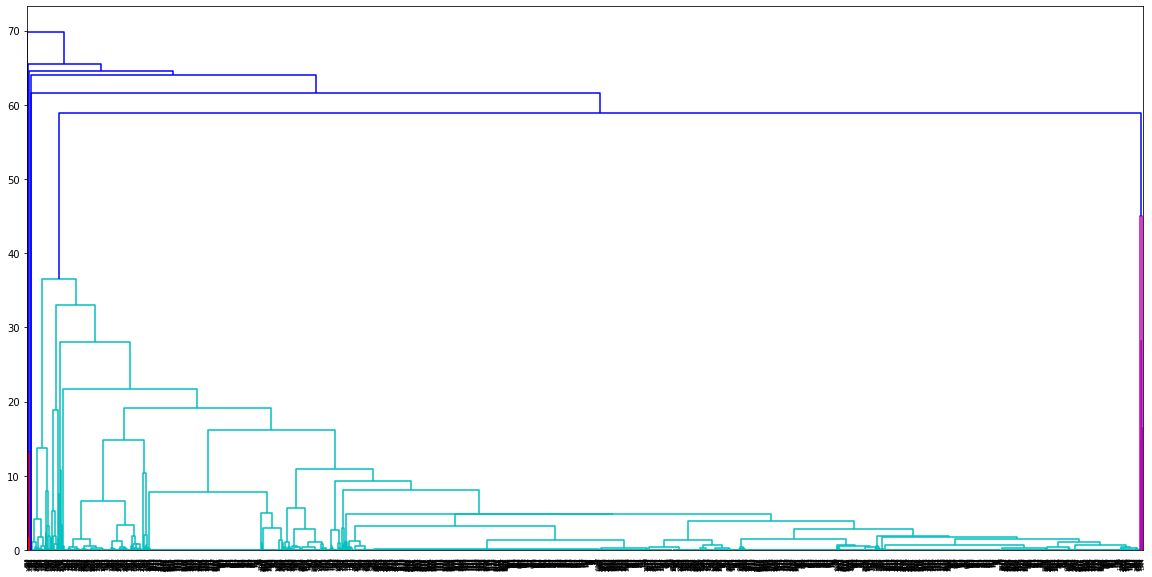

In [24]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [25]:
n_clusters=10
km = KMeans(n_clusters)
labels = km.fit_predict(x_sc)

customers['cluster_km'] = labels
cm = sns.light_palette("green", as_cmap=True)
customers.groupby('cluster_km').mean().style.background_gradient(cmap=cm)

,для ванной,для дачи,для дома,для кухни,для ремонта,растения,"сумки, тележки"
cluster_km,,,,,,,
0,0.199082,0.00375626,0.770451,0.614357,0.456177,2.17821,0.156093
1,1000,0,0,0,0,0,0
2,0,4,0,0,0,0,0
3,0,0,0,0,0,0,58.5
4,0,0,0,0,0,900,0
5,0,0,0,0,600,0,0
6,0,0,334,0,0,0,0
7,0,0,0.594595,50.6216,0.0810811,0.135135,0
8,6.16667,0.166667,110,37.8333,25,14.8333,4.16667


In [26]:
customers['cluster_km'].value_counts()

0    2396
7      37
8       6
2       5
3       2
9       1
5       1
1       1
6       1
4       1
Name: cluster_km, dtype: int64

In [27]:
score = silhouette_score(X, labels)
print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 10, silhouette score is -0.03796224537029033)


Как говорится, очень интересно, но ничего непонятно. Разбиение на кластеры получилось неравномерным, а также метрика силуэта показывает низкие значения при небольшом количестве кластеров. Это могло произойти из-за того, что мы имеем выбросы - когда один пользователь покупает значительно больше товаров, чем остальные. Очистим данные от таких выбросов и попробуем еще раз

Уберем из данных по 1% пользователей, которые покупали товаров отдельной категории больше, чем остальные

In [28]:
for column in X.columns:
    print('{}, 99-й персентиль: {}'.format(column, np.percentile(X[column], 99)))

для ванной, 99-й персентиль: 3.5
для дачи, 99-й персентиль: 0.0
для дома, 99-й персентиль: 20.0
для кухни, 99-й персентиль: 38.0
для ремонта, 99-й персентиль: 5.0
растения, 99-й персентиль: 32.5
сумки, тележки, 99-й персентиль: 2.0


In [29]:
customers_new = customers[np.logical_and(customers['для ванной'] <= (math.floor(np.percentile(customers['для ванной'], 99))+1),
                                         customers['для дачи'] <= (math.floor(np.percentile(customers['для дачи'], 99))+1))]

customers_new = customers_new[np.logical_and(customers['для дома'] <= (math.floor(np.percentile(customers['для дома'], 99))+1),
                                         customers['для кухни'] <= (math.floor(np.percentile(customers['для кухни'], 99))+1))]

customers_new = customers_new[np.logical_and(customers['для ремонта'] <= (math.floor(np.percentile(customers['для ремонта'], 99))+1),
                                         customers['растения'] <= (math.floor(np.percentile(customers['растения'], 99))+1))]

customers_new = customers_new[customers['сумки, тележки'] <= (math.floor(np.percentile(customers['сумки, тележки'], 99))+1)]
customers_new.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


,для ванной,для дачи,для дома,для кухни,для ремонта,растения,"сумки, тележки",cluster_km
count,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000
mean,0.093830,0.003856,0.556127,0.826050,0.054841,1.690660,0.147386,0.044987
std,0.393066,0.061990,1.592167,3.417347,0.383422,4.485852,0.419876,0.559482
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,4.000000,1.000000,20.000000,36.000000,6.000000,33.000000,3.000000,7.000000


Посмотрим на то, какой процент пользователей мы потеряли

In [30]:
print("{:.1%}".format((len(customers) - len(customers_new))/len(customers)))

4.8%


Проделаем те же операции еще раз

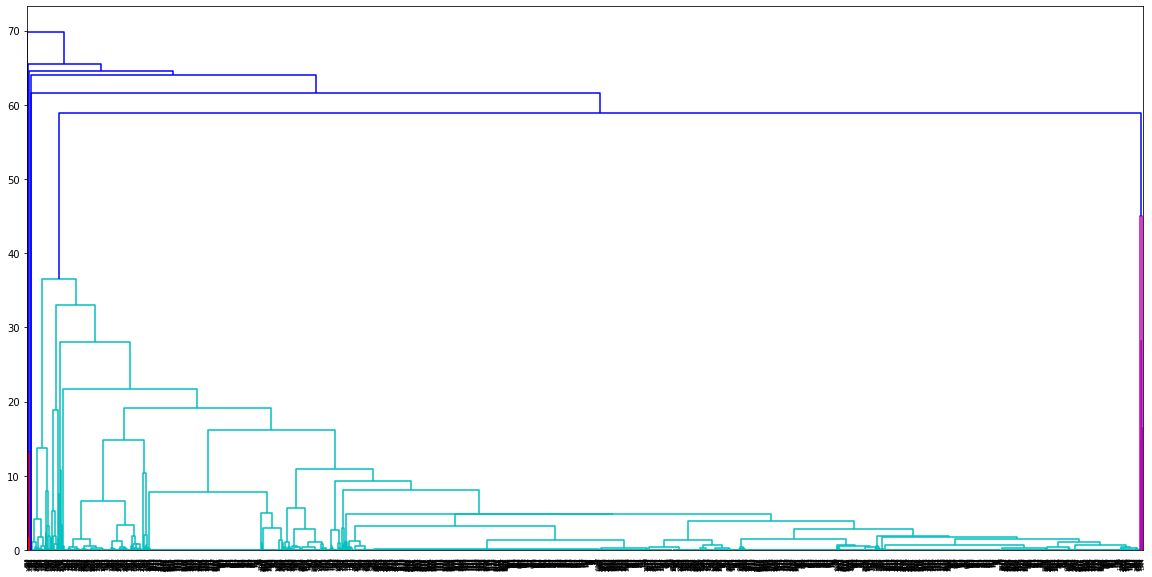

In [31]:
X_new = customers_new.drop('customer_id', axis=1)
x_sc_new = sc.fit_transform(X_new)

linked_new = linkage(x_sc_new, method = 'ward')

plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [32]:
n_clusters_new=13
km = KMeans(n_clusters_new)
labels_new = km.fit_predict(x_sc_new)

customers_new['cluster_km'] = labels_new
cm = sns.light_palette("green", as_cmap=True)
customers_new.groupby('cluster_km').mean().style.background_gradient(cmap=cm)

,для ванной,для дачи,для дома,для кухни,для ремонта,растения,"сумки, тележки"
cluster_km,,,,,,,
0,0,0,0,0.843529,0,1.18824,0
1,0,0,0,30.8,0,0.333333,0
2,0,1,0.222222,0.333333,0,0,0
3,0,0,0,0.152542,0,23.8136,0
4,1,0,0.0990991,0.0630631,0,0.0900901,0
5,0,0,0.00689655,0.0275862,0,0.00689655,1.17241
6,0,0,12.92,0.08,0,0,0
7,0,0,0.25,0,4.41667,0,0
8,0.0444444,0,0.0222222,15.3556,0,0,0


In [33]:
customers_new['cluster_km'].value_counts()

0     850
9     659
5     290
11    152
4     111
10     63
3      59
8      45
12     44
6      25
1      15
7      12
2       9
Name: cluster_km, dtype: int64

In [34]:
score = silhouette_score(X_new, labels_new)
print("For n_clusters = {}, silhouette score is {})".format(n_clusters_new, score))

For n_clusters = 13, silhouette score is 0.4210719409282659)


Совсем другое дело: мы имеем около 45% выделяемости при 13 кластерах. Этот показатель можно увеличить при увеличении количества кластеров, однако резонность этого нужно обсуждать с экспертами. Уже сейчас мы имеет 13 сегментов пользователей, которые можно разбить на 3 группы:
- первая группа: любители категорий с небольшим ассортиментом товаров (*для дачи* и *сумки, тележки*): предлагаем купить товар не только себе, но и другу; просим обратить внимание на товары из других категорий;
- вторая группа: кластеры, в которых среднее число покупок по "любимой" категории сильно больше, чем у других (выделено темно-зеленым): делаем персональное предложение "скидка на n-й товар из данной категории" или "n-й товар бесплатно";
- третья группа: оставшиеся кластеры - рекомендуем товары из любимых категорий

## Проверка статистической значимости

По приведенной выше таблице мы видим, что сегменты 3, 4 и 8 различаются по среднему количеству купленных товаров из категории *растения*, однако данные выводы верны лишь для наших выборок. Проверим гипотезы о равенстве средних данных выборок, чтобы с некоторой уверенностью говорить о том, что генеральные совокупности также различаются. Для этого воспользуемся *критерием Манна-Уитни* и *поправкой по методу Холма* для того, чтобы снизить вероятность ошибок первого рода.

**Нулевая гипотеза** будет звучать так: распределение купленных товаров категории *растения* сегментов пользователей 3, 4 и 8 схожи между собой. **Альтернативная** - распределения купленных товаров категории *растения* имеют разные характер для данных сегментов.

In [35]:
correction = 3
alpha = 0.05

for i in [[3,4], [3,8], [4,8]]:
    results = st.mannwhitneyu(customers_new.query('cluster_km == @i[0]')['растения'], customers_new.query('cluster_km == @i[1]')['растения'])
    print('Значение pvalue для сегментов {} и {}: {:.3}'.format(i[0], i[1], results.pvalue ))
    if results.pvalue < alpha / correction:
        print('Отвергаем нулевую гипотезу: между распределения есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что у распределений есть значимая разница\n')
    correction -= 1

Значение pvalue для сегментов 3 и 4: 8.75e-36
Отвергаем нулевую гипотезу: между распределения есть значимая разница

Значение pvalue для сегментов 3 и 8: 4.88e-20
Отвергаем нулевую гипотезу: между распределения есть значимая разница

Значение pvalue для сегментов 4 и 8: 0.135
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что у распределений есть значимая разница



Как мы видим, значения *pvalue* для всех тестов очень низкий. Это означает, что с большой долей вероятности генеральные совокупности также различные

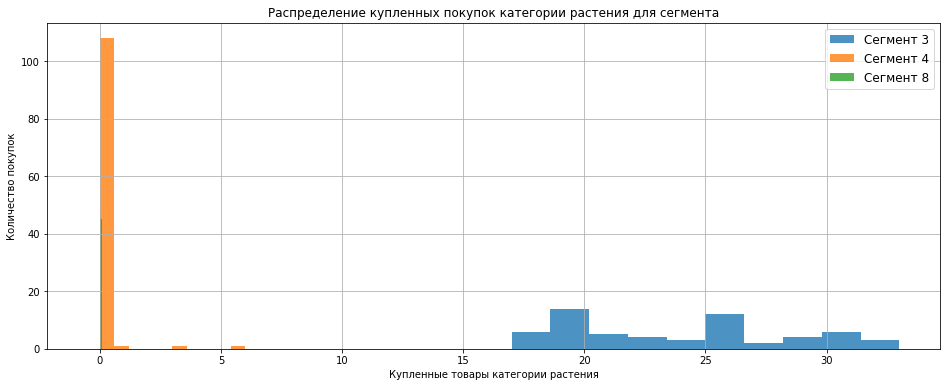

In [36]:
plt.figure(figsize=(16, 6))
plt.hist(customers_new.query('cluster_km == 3')['растения'], label='Сегмент 3', alpha = 0.8)
plt.hist(customers_new.query('cluster_km == 4')['растения'], label='Сегмент 4', alpha = 0.8)
plt.hist(customers_new.query('cluster_km == 8')['растения'], label='Сегмент 8', alpha = 0.8)
plt.xlabel('Купленные товары категории растения')
plt.ylabel('Количество покупок')
plt.title('Распределение купленных покупок категории растения для сегмента')
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

# Выводы

- Этап предобработки данных показал, что мы располагаем корректными данными: пропусков и дубликатов не было, типы данных правильные, названия столбцов в нужном формате;
- Произведена полуавтоматическая сортировка товаров по предполагаемым категориям, в результате которой каждому товару была присвоена категория;
- Создана таблица, показывающая профиль потребления пользователей, в которой для каждого покупателя найдено количество купленных товаров каждой категории;
- Удалены выбросы по числу покупок в каждой из категорий (всего: 4,8% пользователей) - таких пользователей можно считать оптовиками;
- Оставшиеся пользователи разбиты на 13 кластеров, для которых может быть выстроена следующая стратегия:
- - любители категорий с небольшим ассортиментом товаров (*для дачи* и *сумки, тележки*): предлагаем купить товар не только себе, но и другу; просим обратить внимание на товары из других категорий;
- - кластеры, в которых среднее число покупок по "любимой" категории сильно больше, чем у других (выделено темно-зеленым): делаем персональное предложение "скидка на n-й товар из данной категории" или "n-й товар бесплатно";
- - оставшиеся кластеры - рекомендуем товары из любимых категорий
- Проведены тесты, подтверждающие, что разбиение на сегменты не случайно